In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
df = pd.read_csv('online_shoppers_intention (1).csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
model = Logit(y, X).fit()
print(model.summary())

NameError: name 'y' is not defined

In [10]:
model = Logit(y, scaled_X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.527328
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Revenue   No. Observations:                12330
Model:                          Logit   Df Residuals:                    12313
Method:                           MLE   Df Model:                           16
Date:                Fri, 19 May 2023   Pseudo R-squ.:                 -0.2239
Time:                        10:57:19   Log-Likelihood:                -6502.0
converged:                       True   LL-Null:                       -5312.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Administrative              -0.1126      0.030     -3.735      0.000      -0.172

<h3> Effect of label encoding</h3>

In [22]:
df["OperatingSystems_agg"] = df["OperatingSystems"].apply(lambda x: "other" if x >=4 else x)
df["Browser_agg"] = df["Browser"].apply(lambda x: "other" if x not in [1,2,4] else x)

traffic_type_pct = 100*df["TrafficType"].value_counts().to_frame()/df.shape[0]
traffic_idx_list = traffic_type_pct[traffic_type_pct["TrafficType"] >= 2].index
df["TrafficType_agg"] = df["TrafficType"].apply(lambda x: x if x in traffic_idx_list else "other")

df["AllPageCount"] = df[["Administrative", "Informational", "ProductRelated"]].sum(axis=1)
df["AllPageCount_Duration"] = df[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].sum(axis=1)

df["BounceRates_x_PageValues"] = df["BounceRates in %"] * df["PageValues"]

In [23]:
[col for col in df.columns if df[col].dtypes == 'object']

['Month',
 'VisitorType',
 'OperatingSystems_agg',
 'Browser_agg',
 'TrafficType_agg']

In [15]:
df['VisitorType'] = pd.factorize(df['VisitorType'])[0]
df['Month'] = pd.factorize(df['Month'])[0]
df['OperatingSystems_agg'] = pd.factorize(df['OperatingSystems_agg'])[0]
df['Browser_agg'] = pd.factorize(df['Browser_agg'])[0]
df['TrafficType_agg'] = pd.factorize(df['TrafficType_agg'])[0]

In [ ]:
outlier_col = ['Administrative_Duration', 'ProductRelated_Duration', 'BounceRates in %', 'SpecialDay (probability)', 
               'ExitRates in %', 'PageValues', 'Informational_Duration']

for i in range(len(outlier_col)):    
    lv, uv = np.percentile(df[[outlier_col[i]]], [0,98])  
    df[[outlier_col[i]]] = np.clip(df[[outlier_col[i]]], lv, uv)

In [16]:
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [17]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y.values, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1968
           1       0.71      0.54      0.61       498

    accuracy                           0.86      2466
   macro avg       0.80      0.74      0.76      2466
weighted avg       0.85      0.86      0.86      2466



<h3> Effect of scaling and label encoding</h3>

In [11]:
df['VisitorType'] = pd.factorize(df['VisitorType'])[0]
df['Month'] = pd.factorize(df['Month'])[0]

In [12]:
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [13]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [19]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [20]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1958
           1       0.72      0.54      0.62       508

    accuracy                           0.86      2466
   macro avg       0.80      0.74      0.77      2466
weighted avg       0.85      0.86      0.85      2466



In [100]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1993
           1       0.73      0.59      0.65       473

    accuracy                           0.88      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.87      0.88      0.88      2466



In [16]:
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1961
           1       0.71      0.54      0.62       505

    accuracy                           0.86      2466
   macro avg       0.80      0.74      0.77      2466
weighted avg       0.85      0.86      0.85      2466



<h3> Effect of one hot encoding</h3>

In [25]:
features = [col for col in df.columns if df[col].dtypes == 'object']
features

['Month',
 'VisitorType',
 'OperatingSystems_agg',
 'Browser_agg',
 'TrafficType_agg']

In [26]:
df = pd.get_dummies(data=df, columns=features)

In [27]:
df['Revenue'] = df['Revenue'].astype('int64')

In [28]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y.values, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1936
           1       0.73      0.52      0.61       530

    accuracy                           0.85      2466
   macro avg       0.80      0.73      0.76      2466
weighted avg       0.85      0.85      0.85      2466



<h3> Effect of scaling and one hot encoding</h3>

In [30]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1898
           1       0.74      0.50      0.59       568

    accuracy                           0.84      2466
   macro avg       0.80      0.72      0.75      2466
weighted avg       0.83      0.84      0.83      2466



In [23]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1870
           1       0.71      0.45      0.55       596

    accuracy                           0.82      2466
   macro avg       0.78      0.70      0.72      2466
weighted avg       0.81      0.82      0.81      2466



In [24]:
scaler = RobustScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1961
           1       0.71      0.54      0.62       505

    accuracy                           0.86      2466
   macro avg       0.80      0.74      0.77      2466
weighted avg       0.85      0.86      0.85      2466



In [25]:
vals_to_transform = df.skew(numeric_only=True).head(9).index.tolist()

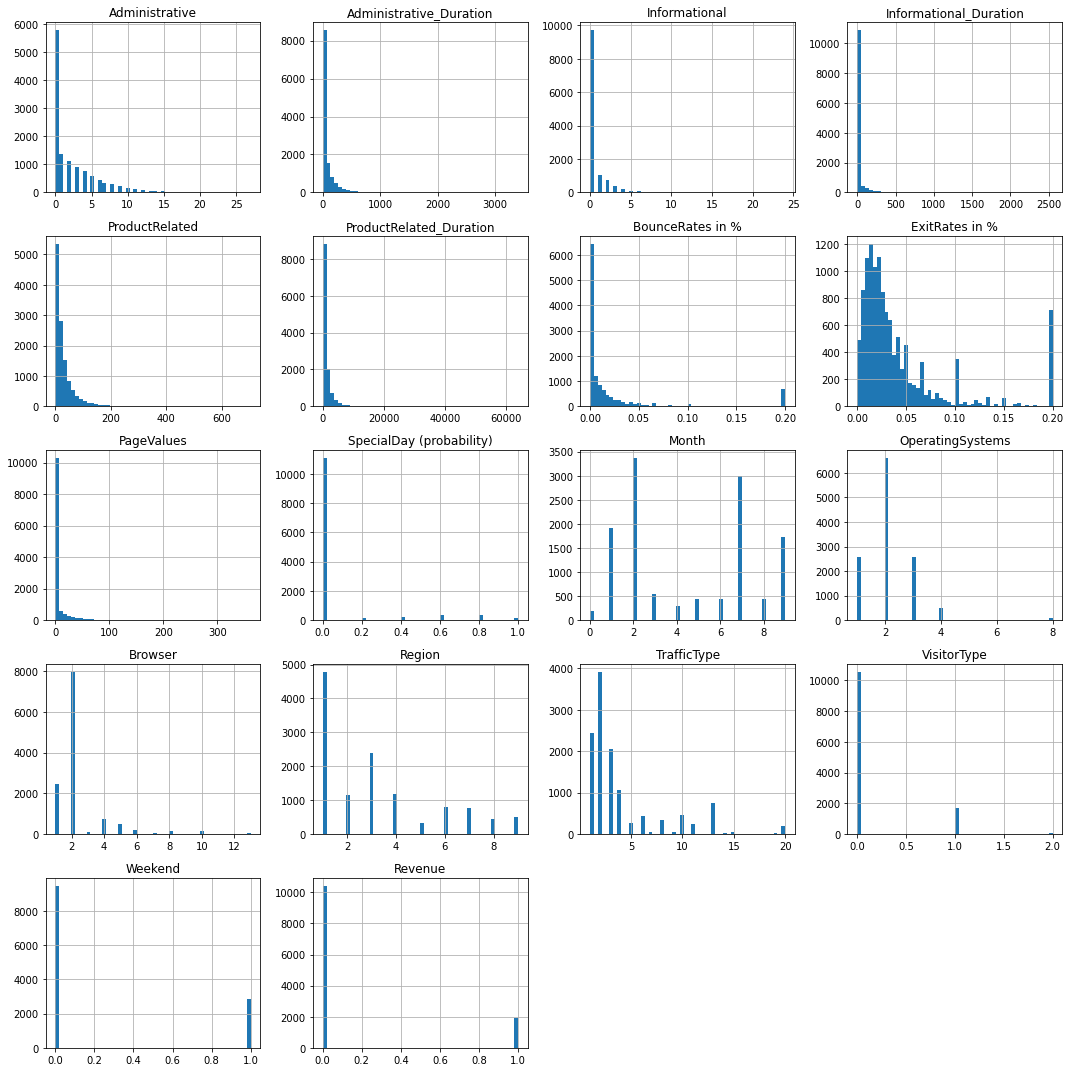

In [26]:
df.hist(figsize=(15, 15), bins=50)
plt.tight_layout()
plt.show()

In [27]:
for col in vals_to_transform:
    df.loc[:, col] = np.log1p(df[col])

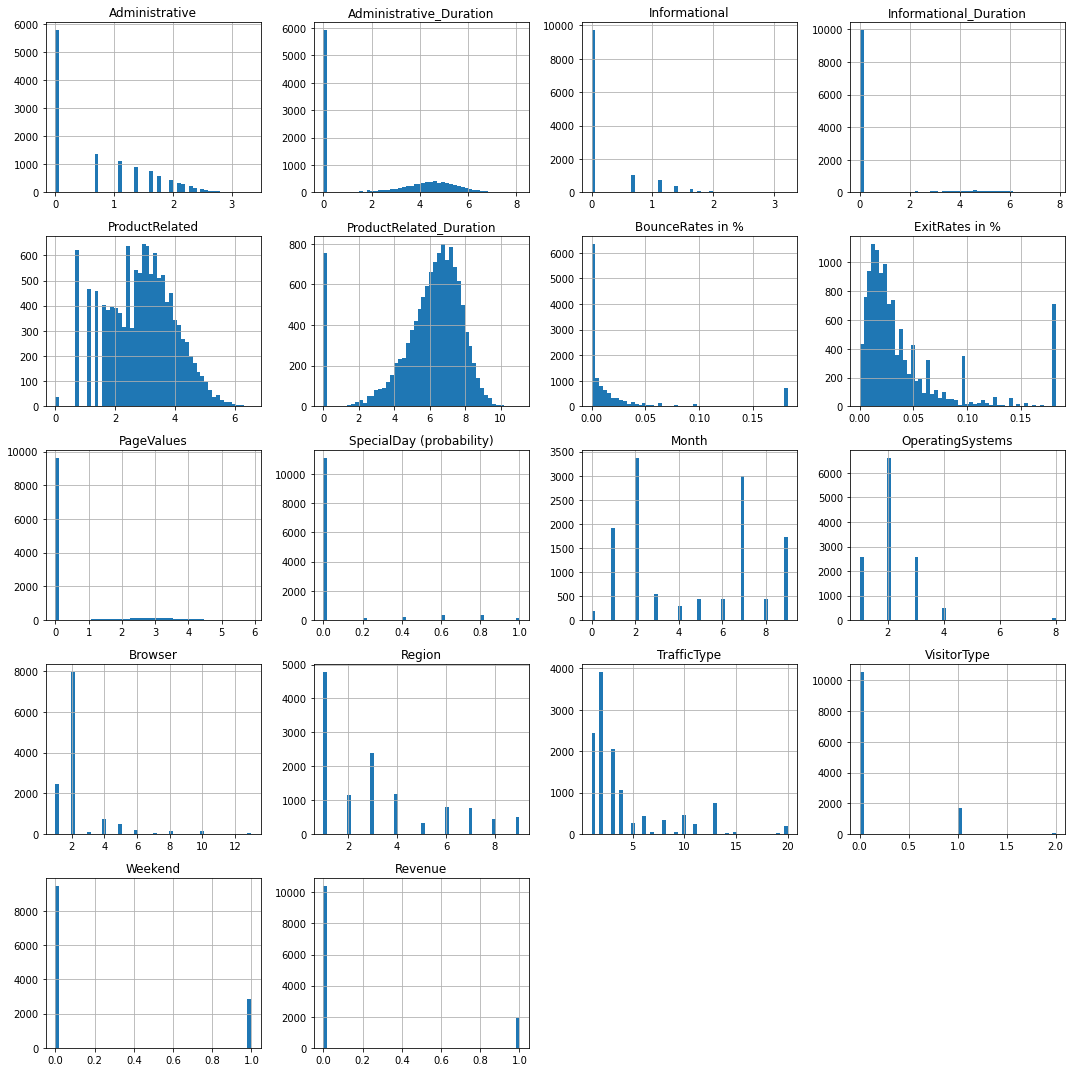

In [28]:
df.hist(figsize=(15, 15), bins=50)
plt.tight_layout()
plt.show()

In [29]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1946
           1       0.76      0.56      0.64       520

    accuracy                           0.87      2466
   macro avg       0.82      0.75      0.78      2466
weighted avg       0.86      0.87      0.86      2466



<h3> Clipping out page values where Revenue generated == False </h3>

In [310]:
df['PageValues'] = np.where((df['PageValues'] > 0) & (df['Revenue'] == False), 0, df['PageValues'])

In [95]:
df.corr()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
Administrative,1.000000,0.601583,0.376850,0.255848,0.431119,0.373939,-0.223563,-0.316483,0.024258,-0.094778,0.078698,-0.006347,-0.025035,-0.005487,-0.033561,0.016680,0.026417,0.138917
Administrative_Duration,0.601583,1.000000,0.302710,0.238031,0.289087,0.355422,-0.144170,-0.205798,0.022460,-0.073304,0.045888,-0.007343,-0.015392,-0.005561,-0.014376,0.019120,0.014990,0.093587
Informational,0.376850,0.302710,1.000000,0.618955,0.374164,0.387505,-0.116114,-0.163666,0.002980,-0.048219,0.060826,-0.009527,-0.038235,-0.029169,-0.034491,-0.058211,0.035785,0.095200
Informational_Duration,0.255848,0.238031,0.618955,1.000000,0.280046,0.347364,-0.074067,-0.105276,0.001673,-0.030577,0.041282,-0.009579,-0.019285,-0.027144,-0.024675,-0.045372,0.024078,0.070345
ProductRelated,0.431119,0.289087,0.374164,0.280046,1.000000,0.860927,-0.204578,-0.292526,0.017382,-0.023958,0.137077,0.004290,-0.013146,-0.038122,-0.043064,-0.127916,0.016092,0.158538
ProductRelated_Duration,0.373939,0.355422,0.387505,0.347364,0.860927,1.000000,-0.184541,-0.251984,0.019866,-0.036380,0.124053,0.002976,-0.007380,-0.033091,-0.036377,-0.118273,0.007311,0.152373
BounceRates in %,-0.223563,-0.144170,-0.116114,-0.074067,-0.204578,-0.184541,1.000000,0.913004,-0.099839,0.072702,-0.059301,0.023823,-0.015772,-0.006485,0.078286,-0.114916,-0.046514,-0.150673
ExitRates in %,-0.316483,-0.205798,-0.163666,-0.105276,-0.292526,-0.251984,0.913004,1.000000,-0.145187,0.102242,-0.083028,0.014567,-0.004442,-0.008907,0.078616,-0.152678,-0.062587,-0.207071
PageValues,0.024258,0.022460,0.002980,0.001673,0.017382,0.019866,-0.099839,-0.145187,1.000000,-0.052933,0.042264,0.017199,0.053732,0.012956,0.022525,0.146029,0.017389,0.580255
SpecialDay (probability),-0.094778,-0.073304,-0.048219,-0.030577,-0.023958,-0.036380,0.072702,0.102242,-0.052933,1.000000,-0.277549,0.012652,0.003499,-0.016098,0.052301,-0.086854,-0.016767,-0.082305


In [31]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [32]:
model = LogisticRegression(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4847
           1       0.78      0.57      0.66      1318

    accuracy                           0.87      6165
   macro avg       0.84      0.76      0.79      6165
weighted avg       0.87      0.87      0.87      6165



In [157]:
model.coef_

array([[ 0.32260075, -0.05213614,  0.84516136, -0.19885379,  0.42501871,
        -0.20750249, -2.87309803, -2.2180856 ,  5.2420872 , -2.09984042,
         0.29956793, -0.12740744,  0.02564078, -0.02925223,  0.02868643,
         0.51720679,  0.13297235]])

In [33]:
from sklearn.decomposition import PCA

In [34]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [35]:
pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_df)

In [36]:
pca_df = pd.DataFrame(data=pca_df, columns=['principal component 1', 'principal component 2'])
pca_df['y'] = y

In [37]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26034601 0.10312508]


<Figure size 432x288 with 0 Axes>

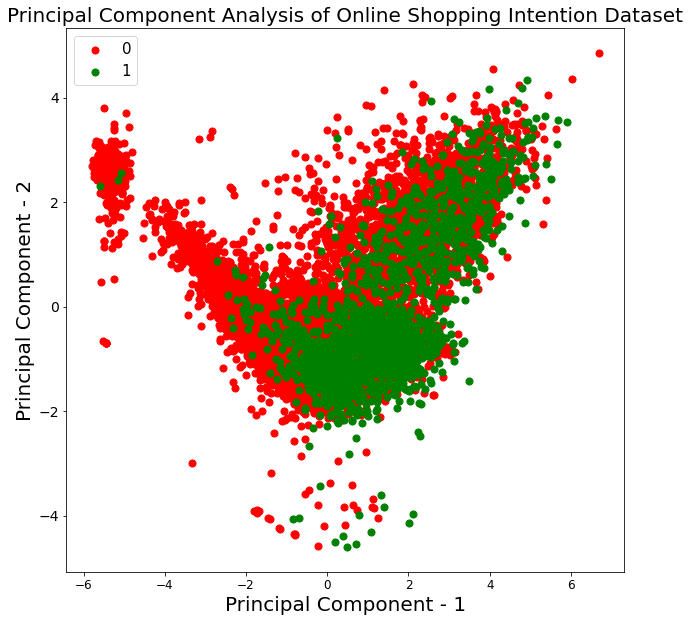

In [38]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Online Shopping Intention Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['Revenue'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

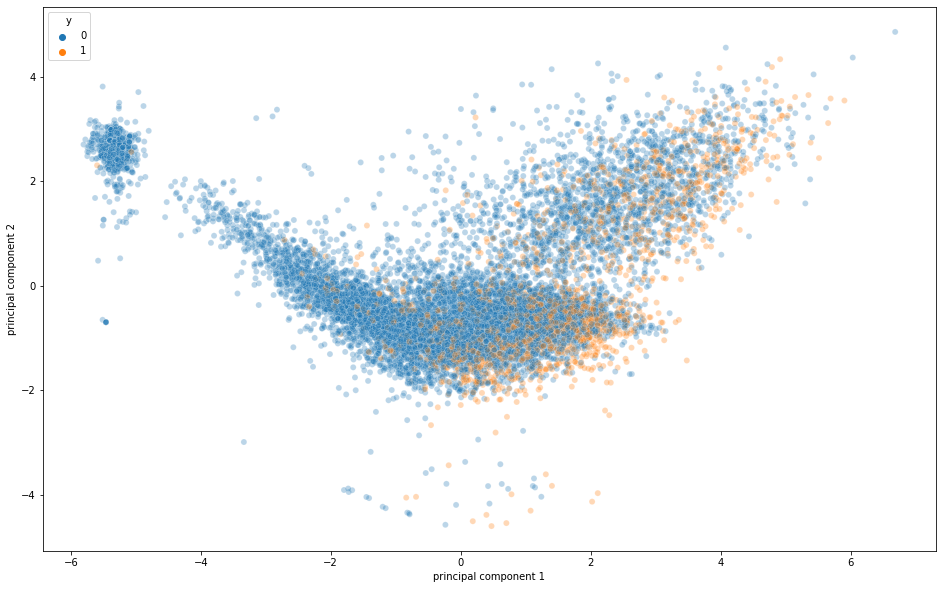

In [39]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    data=pca_df,
    legend="full",
    alpha=0.3
)


In [40]:
from sklearn.pipeline import Pipeline

In [41]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)), ('model', LogisticRegression(
                                                                                        max_iter=10000, 
                                                                                        random_state=123, 
                                                                                        class_weight='balanced'))])

In [42]:
y_train.value_counts()

0    5211
1     954
Name: Revenue, dtype: int64

In [43]:
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

print(confusion_matrix(preds, y_test))
print(classification_report(preds, y_test))

[[4646  206]
 [ 565  748]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4852
           1       0.78      0.57      0.66      1313

    accuracy                           0.87      6165
   macro avg       0.84      0.76      0.79      6165
weighted avg       0.87      0.87      0.87      6165



In [228]:
from sklearn.linear_model import RidgeClassifier

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y.values, test_size=0.2, random_state=42)

model = RidgeClassifier(max_iter=10000, random_state=123, class_weight='balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1849
           1       0.68      0.42      0.52       617

    accuracy                           0.80      2466
   macro avg       0.75      0.68      0.70      2466
weighted avg       0.79      0.80      0.79      2466



In [265]:
model.feature_names_in_

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates in %', 'ExitRates in %',
       'PageValues', 'SpecialDay (probability)', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'VisitorType', 'Weekend'], dtype=object)

In [46]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [47]:
X_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates in %,ExitRates in %,PageValues,SpecialDay (probability),Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
5,0.000000,0.000000,0.0,0.0,2.995732,5.044822,0.015666,0.024265,0.000000,0.0,0,2,2,1,3,0,0
7,0.693147,0.000000,0.0,0.0,0.000000,0.000000,0.182322,0.182322,0.000000,0.0,0,1,2,1,5,0,1
8,0.000000,0.000000,0.0,0.0,1.098612,3.637586,0.000000,0.095310,0.000000,0.8,0,2,2,2,3,0,0
9,0.000000,0.000000,0.0,0.0,1.386294,6.605298,0.000000,0.021979,0.000000,0.4,0,2,4,1,2,0,0
10,0.000000,0.000000,0.0,0.0,1.386294,5.981414,0.000000,0.064539,0.000000,0.0,0,1,1,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12318,0.000000,0.000000,0.0,0.0,1.945910,5.634790,0.000000,0.032790,0.000000,0.0,9,1,2,3,10,0,1
12319,0.000000,0.000000,0.0,0.0,3.091042,7.029604,0.000000,0.012959,1.544451,0.0,9,2,2,1,2,0,0
12322,1.945910,4.347047,0.0,0.0,3.135494,6.981238,0.000000,0.004158,0.000000,0.0,9,2,2,4,2,0,0
12328,1.609438,4.330733,0.0,0.0,2.772589,5.849325,0.000000,0.020834,0.000000,0.0,7,2,2,3,11,0,0


In [48]:
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_df, y, stratify=y.values, 
                                                                  test_size=0.2, random_state=42)

In [31]:
model = RandomForestClassifier(n_estimators=1000, random_state=123, class_weight='balanced')
model.fit(scaled_X_train, y_train)
preds = model.predict(scaled_X_test)

print(classification_report(preds, y_test))

NameError: name 'RandomForestClassifier' is not defined

In [315]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.reset_index()
feature_importances = feature_importances.rename(columns={0: 'Importance', 'index': 'Features'})

In [316]:
feature_importances

,Features,Importance
0,Administrative,0.016941
1,Administrative_Duration,0.026680
2,Informational,0.007564
3,Informational_Duration,0.011518
4,ProductRelated,0.035095
5,ProductRelated_Duration,0.049962
6,BounceRates in %,0.026542
7,ExitRates in %,0.053081
8,PageValues,0.693007
9,SpecialDay (probability),0.000900


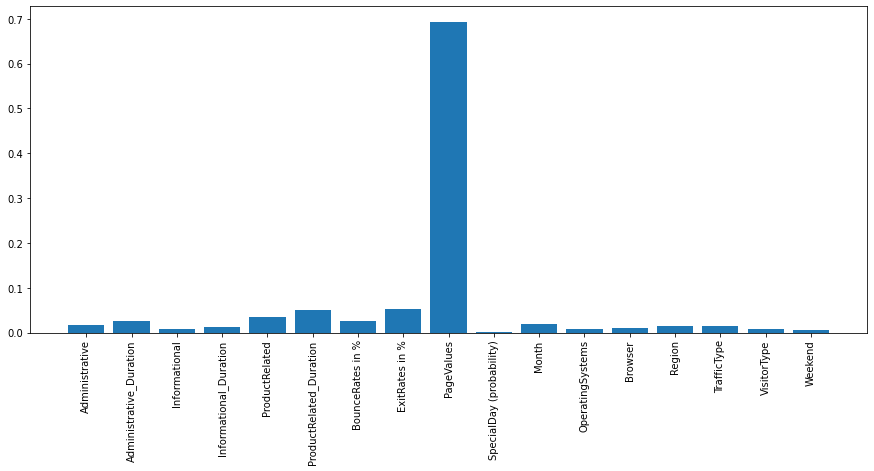

In [317]:
plt.figure(figsize=(15, 6))
plt.bar(feature_importances['Features'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.show()